### Original size

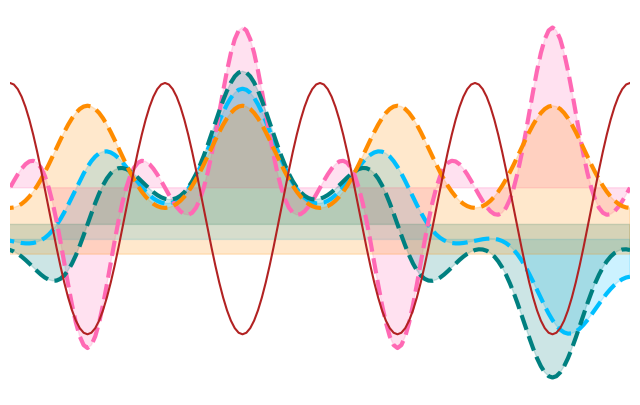

In [4]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz
from tools.fix_phase import fix_phase

nx = 201
nq = 101
wavelength = np.pi
a = wavelength / 2
x = np.linspace(-2.5 * a, 2.5 * a, nx)
lmax = 100
l = np.arange(-lmax, lmax + 1)
V0 = 5
kl = 2 * np.pi / wavelength
qx = np.linspace(-1, 1, nq)  # This is qx/k_lattice
u = np.zeros((*x.shape, *qx.shape), dtype="complex128")
psi = np.zeros((*x.shape, *qx.shape), dtype="complex128")
E = np.zeros(qx.shape)

for qi in range(len(qx)):
    q = qx[qi]
    Hmat = np.diag([(q + 2 * k) ** 2 for k in l])
    Hmat -= (
        V0 / 4 * (np.diag(np.ones(len(l) - 1), 1) + np.diag(np.ones(len(l) - 1), -1))
    )
    evals, evecs = np.linalg.eigh(Hmat)
    idx = evals.argsort()
    evals = evals[idx]
    evecs = evecs[:, idx]

    coefs = evecs[:, 0][None]
    E[qi] = evals[0]
    u[:, qi] = (
        coefs / np.sqrt(2 * np.pi) @ np.exp(1j * np.outer(2 * kl * l, x))
    )  # exp(2ik_l x)
    psi[:, qi] = u[:, qi] * np.exp(-1j * qx[qi] * kl * x)

fig, ax = plt.subplots(figsize=(8, 5))
color = ["hotpink", "teal", "darkorange", "deepskyblue"]
qilist = [0, 25, 50, 67]
for i in range(-1, 3):
    qi = qilist[i]
    plt.plot(x, np.real(psi[:, qi]) + E[qi], lw=3, ls="--", color=color[i])
    plt.fill_between(x, E[qi], np.real(psi[:, qi]) + E[qi], color=color[i], alpha=0.2)
plt.plot(x, (np.sin(kl * x) ** 2 - 1), color="firebrick")

plt.axis("off")
plt.xlim(-1.5 * a, 2.5 * a)
plt.savefig("fig0a.svg", transparent=True, bbox_inches="tight")


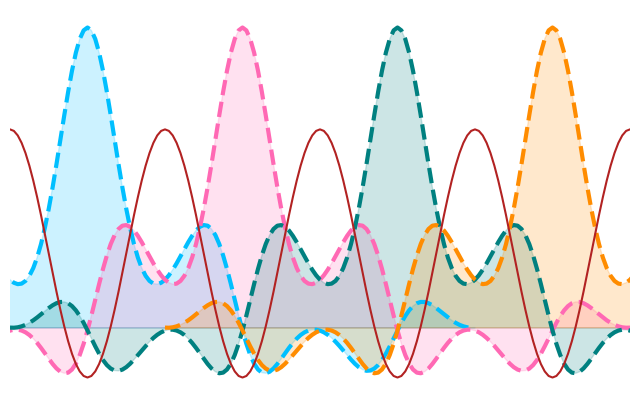

In [5]:
wf = (
    psi[..., None]
    # * np.tile(
    #     np.exp(-1j * kl * np.outer(qx, a * l)[None, ...]),
    #     (nx, 1, 1),
    # )
)  # exp(-ik_l x)
w = trapz(wf, qx, axis=1)

fig, ax = plt.subplots(figsize=(8, 5))
color = ["hotpink", "teal", "darkorange", "deepskyblue"]
for i in range(-1, 3):
    plt.plot(x + a * i, np.real(w[:, 0]) - 0.8, lw=3, ls="--", color=color[i])
    plt.fill_between(x + a * i, -0.8, np.real(w[:, 0]) - 0.8, color=color[i], alpha=0.2)
plt.plot(x, (np.sin(kl * x) ** 2 - 1), color="firebrick")

plt.axis("off")
plt.xlim(-1.5 * a, 2.5 * a)
plt.savefig("fig0b.svg", transparent=True, bbox_inches="tight")


### Figure 0c

In [8]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 4
b = 0
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(100, 1000),
    lc=(1550,),
    dim=3,
    band=b + 1,
    equalize_V0=False,
    ghost=False,
    sparse=True,
    lattice_symmetry=True,
    symmetry=True,
    verbosity=3,
)

E, W, parity = dvr.eigen_basis()
E = E[b]
W = W[b]
p = parity[b]

A, U = singleband_WF(dvr, E, W, p)
print("detU =", la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p, p)
print(dvr.R0[0] * 1)


DVR: dx=[0.15 0.15 0.36]w is set.
DVR: n=[20 20 20] is set.
DVR: R0=[3.  3.  7.2]w is set.
['x' 'y' 'z']-reflection symmetry is used.
param_set: trap parameter V0=100kHz w=1000nm
Lattice: lattice shape is square; lattice constants set to: (1550, 1550)
lattice: lattice shape is square
lattice: Full lattice sizes: [4]
lattice: lattice constants: [1.55 1.55]w
lattice: dx fixed to: [0.15 0.15 0.36]w
DVR: dx=[0.15 0.15 0.36]w is set.
DVR: n=[35 20 20] is set.
DVR: R0=[5.325 3.    7.2  ]w is set.
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.
H_op: n=[35 20 20] dx=[0.15 0.15 0.36]w p=[1 1 1] Gaussian sparse diagonalization starts. Lowest 5 states are to be calculated.
H_op: n=[35 20 20] dx=[0.15 0.15 0.36]w p=[1 1 1] Gaussian operator constructed.
H_solver: diagonalize sparse hermitian matrix.
H_solver: Gaussian Hamiltonian solved. Time spent: 0.49s.
H_solver: eigenstates memory usage:  0.61 MiB.
H_op: n=[35 20 20] dx=[0.15 0.15 0.36]w p=[-1  1  1] Gaussi

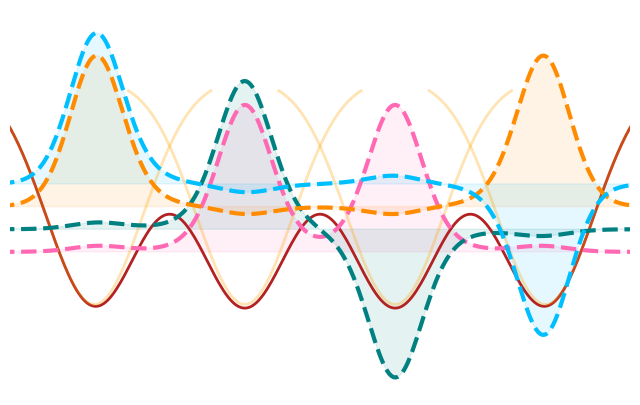

In [15]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt
from DVR.wavefunc import psi


fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.5
pwr = 1

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0], dvr.R0[0], 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
vmin = np.min(v[:180])
vi_scale = -np.sqrt(abs(vmin))
vi_scale = -1

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 0.3
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

x = np.linspace(-dvr.R0[0], dvr.R0[0], 500)
wf = np.zeros((x.shape[0], dvr.lattice.N))
for i in range(p.shape[0]):
    wf[:, i] = (
        wf_scale * fix_phase(psi([x, y, z], dvr.n, dvr.dx, W[i], p[i, :])[:, 0, 0, 0])
        + E[0]
        + 0.1 * i
    )

color = ["hotpink", "teal", "darkorange", "deepskyblue"]
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color=color[i],
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, +E[0] + 0.1 * i, wf[:, i], color=color[i], alpha=shade_alpha)

plt.xlabel("dx")
plt.ylim(-1.4, .3)
plt.xlim(-dvr.R0[0] * edge, dvr.R0[0] * edge)
plt.axis("off")
plt.savefig("fig0c.svg", transparent=True, bbox_inches="tight")


### Figure 0d

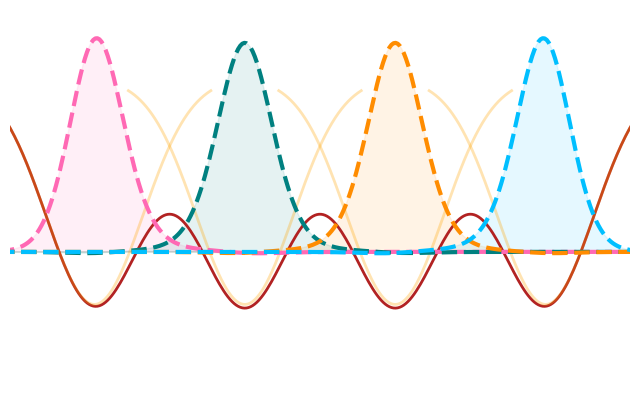

In [14]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.5
pwr = 1

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0], dvr.R0[0], 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
vmin = np.min(v[:180])
vi_scale = -np.sqrt(abs(vmin))
vi_scale = -1
# plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 0.3
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

color = ["hotpink", "teal", "darkorange", "deepskyblue"]
x = np.linspace(-dvr.R0[0], dvr.R0[0], 500)
wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + E[0]
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color=color[i],
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, E[0], wf[:, i], color=color[i], alpha=shade_alpha)

plt.xlabel("dx")
plt.ylim(-1.4, .3)
plt.xlim(-dvr.R0[0] * edge, dvr.R0[0] * edge)
plt.axis("off")
plt.savefig("fig0d.svg", transparent=True, bbox_inches="tight")
